## DistilBERT Graphs

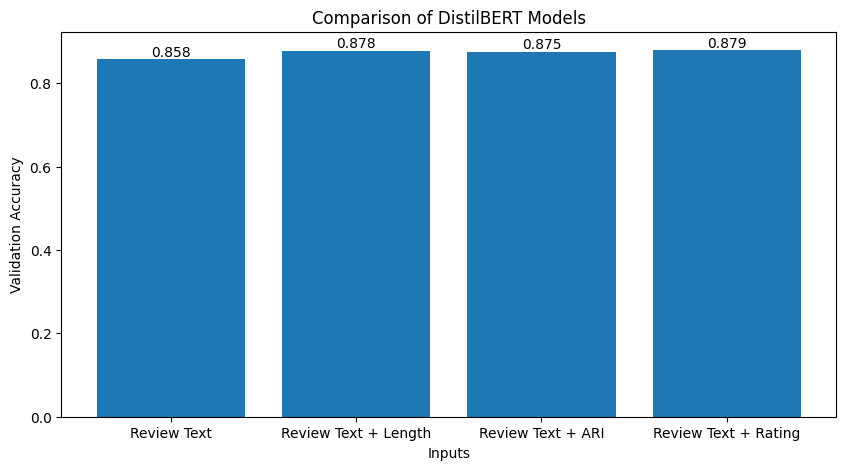

In [8]:
import matplotlib.pyplot as plt

# Validation accuracies
accuracies = [0.8575, 0.8776, 0.875, 0.8793]

# Inputs
inputs = ['Review Text', 'Review Text + Length', 'Review Text + ARI', 'Review Text + Rating']

# Create the bar chart with wider x-axis
plt.figure(figsize=(10, 5)) 
plt.bar(inputs, accuracies)

# Adding labels
plt.xlabel('Inputs')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of DistilBERT Models')

# Annotating the bars with numbers
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f'{acc:.3f}', ha='center', va='bottom')

# Display the plot
plt.show()

### Metriken DistilBERT with Length

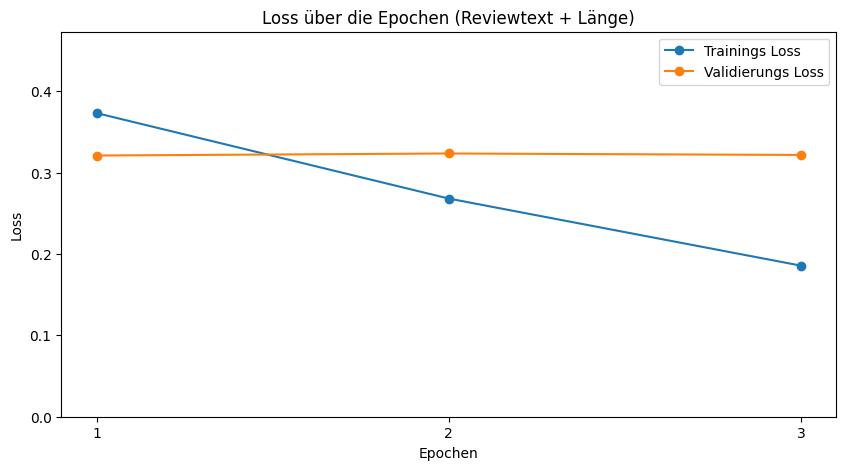

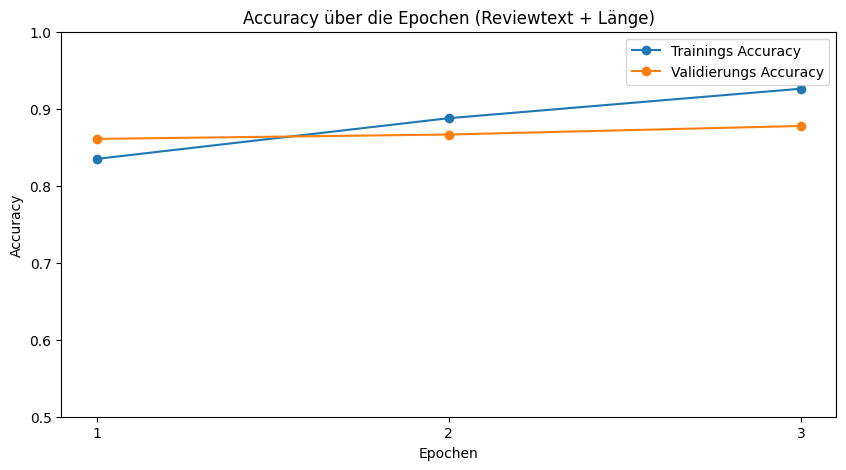

In [9]:
import matplotlib.pyplot as plt

# Trainings- und Validierungsdaten
epochs = [1, 2, 3]
train_loss = [0.3733, 0.2682, 0.1857]
train_accuracy = [0.8348, 0.8877, 0.9260]

val_loss = [0.3211, 0.3236, 0.3218]
val_accuracy = [0.8608, 0.8665, 0.8776]

# Plot für Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Trainings Loss', marker='o')
plt.plot(epochs, val_loss, label='Validierungs Loss', marker='o')
plt.title('Loss über die Epochen (Reviewtext + Länge)')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.xticks(epochs)  # Set x-axis ticks to only show 1, 2, and 3
plt.ylim(0, max(max(train_loss), max(val_loss)) + 0.1) 
plt.legend()
plt.show()

# Plot für Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Trainings Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validierungs Accuracy', marker='o')
plt.title('Accuracy über die Epochen (Reviewtext + Länge)')
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # Set x-axis ticks to only show 1, 2, and 3
plt.ylim(0.5, 1.0) 
plt.legend()
plt.show()

### Metriken DistilBERT with ARI

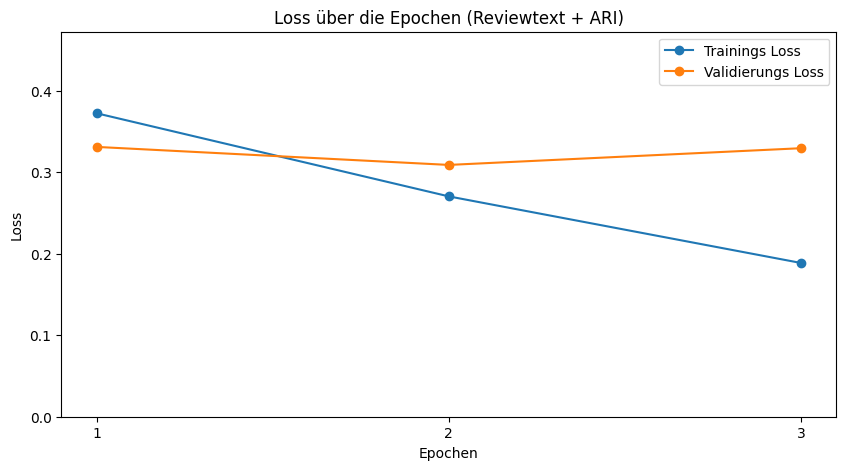

In [10]:
import matplotlib.pyplot as plt

# Trainings- und Validierungsdaten
epochs = [1, 2, 3]
train_loss = [0.3723 , 0.2703, 0.1886]

val_loss = [0.3310 , 0.3089, 0.3294]


# Plot für Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Trainings Loss', marker='o')
plt.plot(epochs, val_loss, label='Validierungs Loss', marker='o')
plt.title('Loss über die Epochen (Reviewtext + ARI)')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.xticks(epochs)  # Set x-axis ticks to only show 1, 2, and 3
plt.ylim(0, max(max(train_loss), max(val_loss)) + 0.1)
plt.legend()
plt.show()